## I. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot

plt.style.use('/Users/mueller/Projects/GitRepos/ICARUSNoiseAnalysis/plot_style.mplstyle')
path = '/Users/mueller/Downloads/'

## II. Signal Rejection
A fundamental requirement for the characterization of noise is the ability to robustly identify waveforms with signal and prevent them from contaminating the results of the noise analysis. The noise analysis is performed on individual waveforms and has access to GausHits present on each waveform. The height of the largest GausHit (defined as the one with the largest summed ADC) can be used as a discriminator for signal. 

The distribution of this quantity will be different for noise-only waveforms and for signal waveforms. We can use data taken with the cathode high voltage turned off to estimate the distribution for noise hits and data taken at nominal drift field to estimate the signal+noise distribution. The difference of these two can provide and estimate of the signal-only distribution. This information is useful for optimizing the signal rejection cut.

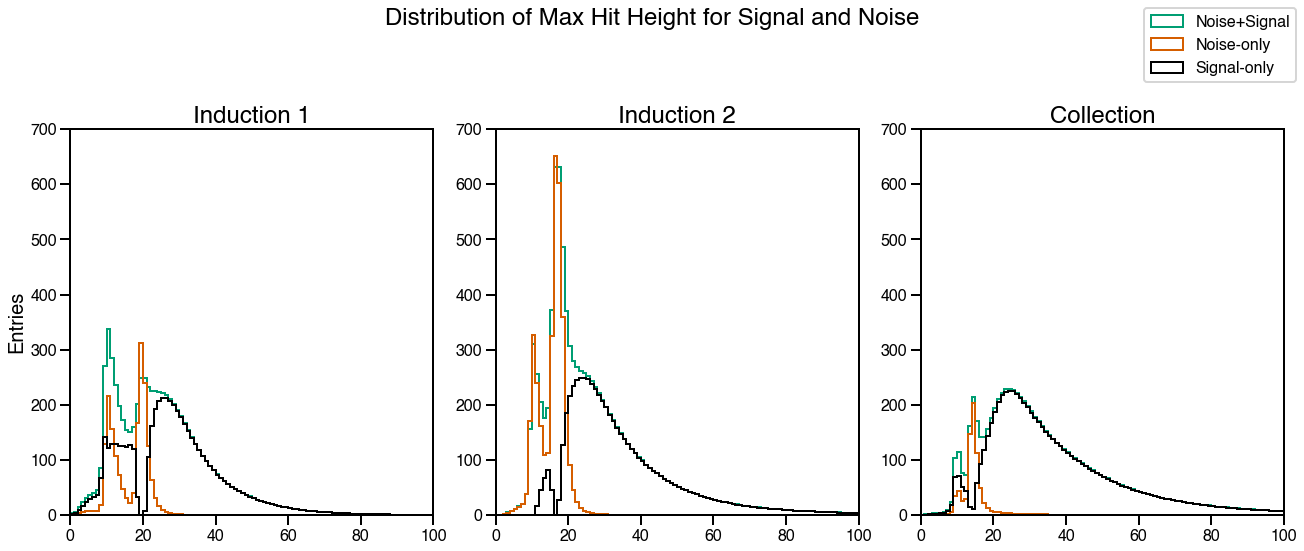

In [2]:
from tpc_channel_status_utilities import *
rfcathodeon = uproot.open(f'{path}diagnose_output_10281.root')
rfcathodeoff = uproot.open(f'{path}diagnose_output_10265.root')

plot_max_signal_height(rfcathodeon, rfcathodeoff)

### Signal rejection and noise acceptance curves
The noise-only and signal-only distributions can be used to quantify the performance of the signal rejection and noise acceptance using the largest hit height as a discriminator. For a simple cut this is just a cumulative distribution. Each plane can be separately optimized to account for differences in the signal characteristics and reconstruction.

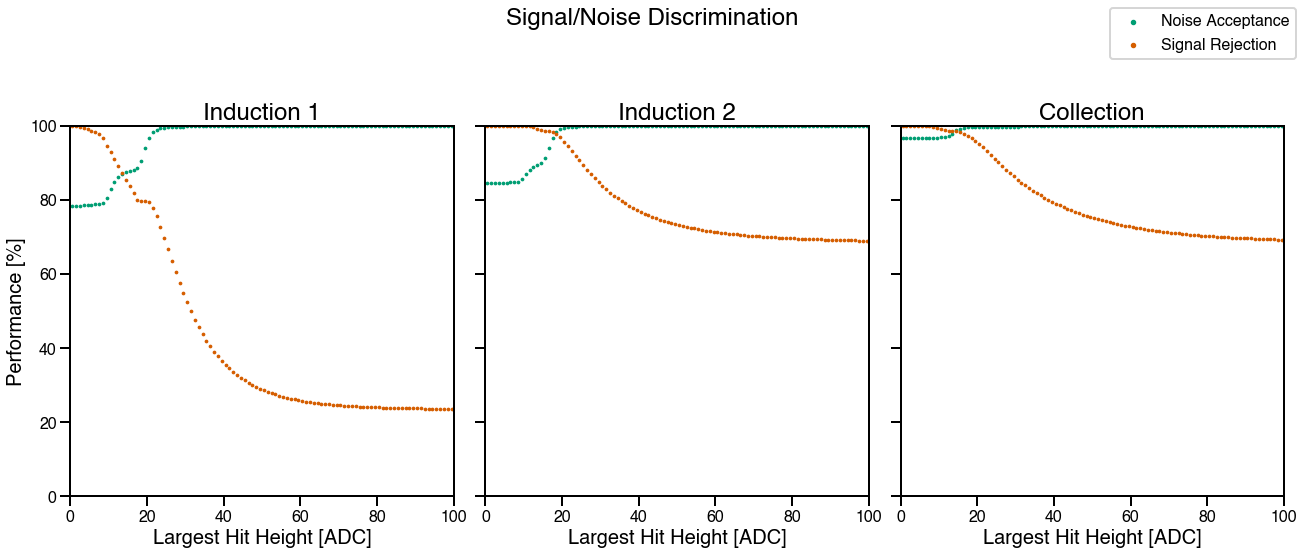

In [3]:
plot_acceptance_rejection_curves(rfcathodeon, rfcathodeoff)

## III. Irregular channel detection

### Using signal rejection (or detection) to look for malfunctioning channels
While noisy channels or dead channels are detectable using the noise characteristics, there may exist channels with normal noise, but no signal. These channels should be detectable by looking at the fraction of events in the channel with obvious signs of signal. As indicated above, a cut on the largest hit height of around 20 ADC will remove nearly all noise-only waveforms and leave most waveforms with signal. 

A program written in C++ is used to count the number of signal occurrences per-channel and save the results in a histogram. This is done for a single example run (Run 10281) from after the end of Run 2. The relevant metric to characterize each channel's sensitivity to signal is "signal occupancy" -- the fraction of waveforms which contain signal. This distribution will naturally look different for each plane as the wire lengths and signal characteristics are different. 

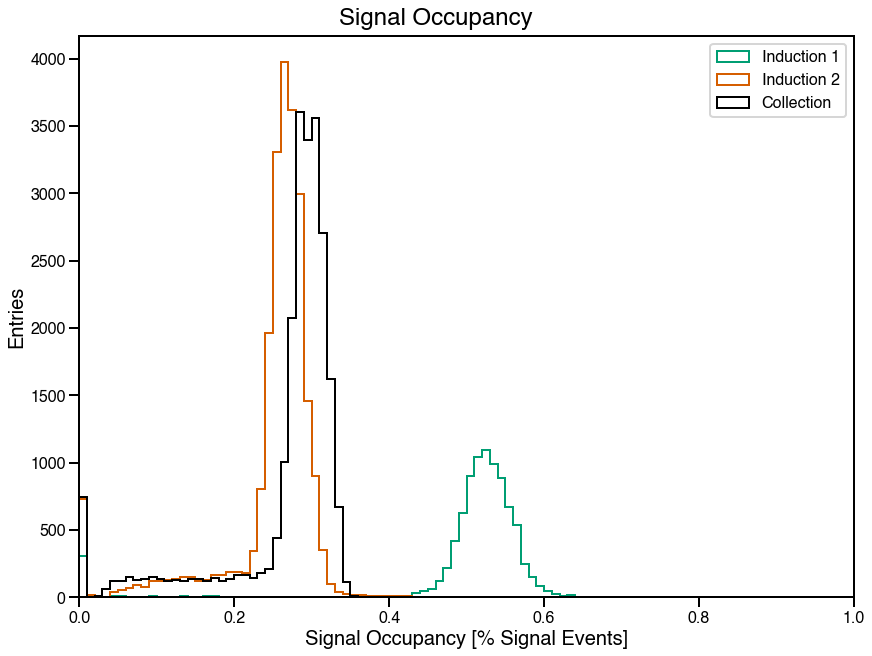

In [4]:
plot_signal_occupancy(rfcathodeon, norm=False)

It is interesting to note that the Induction 2 and Collection planes both have a tail on the low-end of signal occupancy. This is because the effective exposure to signal of each wire is directly proportional to its length. Induction 1 wires have a uniform length, so there is no significant tail to its distribution. On the other hand, Induction 2 and Collection each have a typical wire length, but with some small population of shorter wires in the corners of the detector. This creates a central peak where the main population lives and a long tail stretching to low signal occupancy where the short wires live. 

The signal occupancy can be normalized by the wire length to account for this difference in signal exposure:

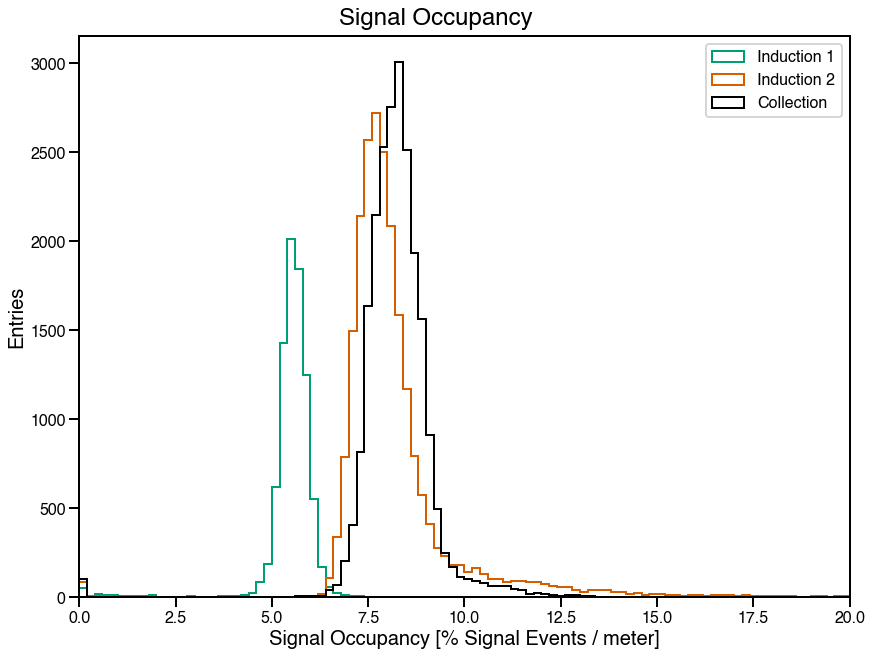

In [5]:
plot_signal_occupancy(rfcathodeon, norm=True)

This distribution clearly suggests that there is a small, distinct set of channels with low signal occupancy. A cut around 0.02 seems to separate the population of nominal channels from irregular ones.

### Channels with irregular noise
There is a small, but significant, population of channels with noise characteristics outside the norm. These channels may be significantly more noisy than others, have virtually no noise, or exhibit some transient behavior somewhere between the two. Channels which are noisy and still see signal may be treated differently in simulation compared to channels which have low noise and see no signal. It is important to categorize these channels accordingly. 

First, we should understand the typical distribution of noise, as measured by the Root-Mean-Square (RMS), for each plane.

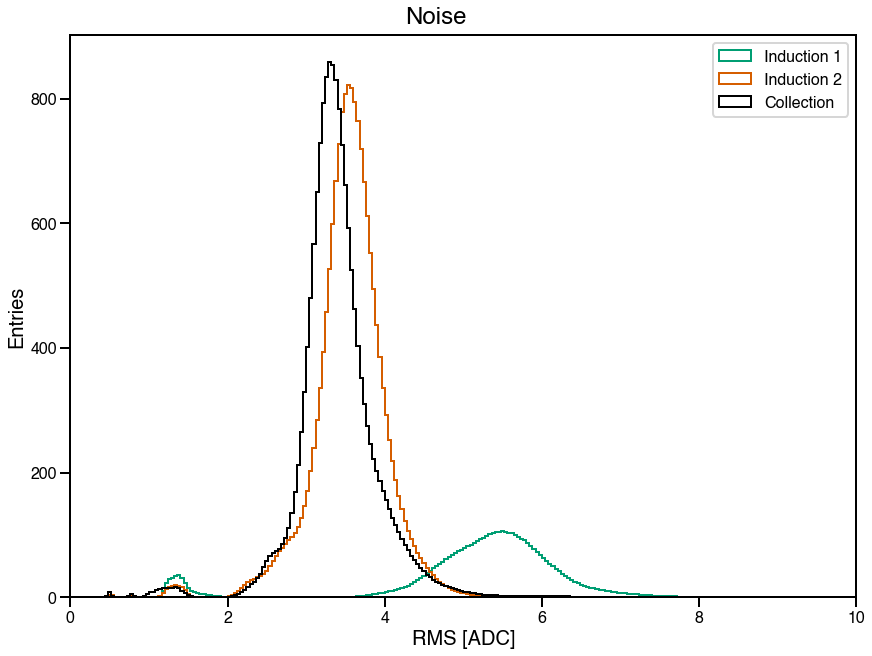

In [6]:
plot_noise(rfcathodeon, norm=False)

As one would expect, we see distinct populations for Induction 1 and Induction 2 / Collection. The simplest explanation is the difference in wire length between these two populations, but this is not the entire story. The Induction 1 wires, despite being uniform in length, are connected to non-uniform length flat cables due to variation in Y-coordinates of wire end points. This causes a broadening of the noise distribution for Induction 1. There are also hints of smaller, distinct populations in the other two planes, which may again be explained by variations in cable length (some Induction 2 / Collection wires are short and/or end on the side). These features make discrimination between bad and good channels a little less clear.

Following a similar approach to the one done for signal occupancy, one can instead apply some normalization using some variable that correlates well to these effects. The most natural choice is the total capacitance of each channel, which should be roughly proportional to the intrinsic noise. From the documentation of the flat cables and the wires, we can estimate the lengths and total capacitance of each channel and use this to normalize the intrinsic noise:

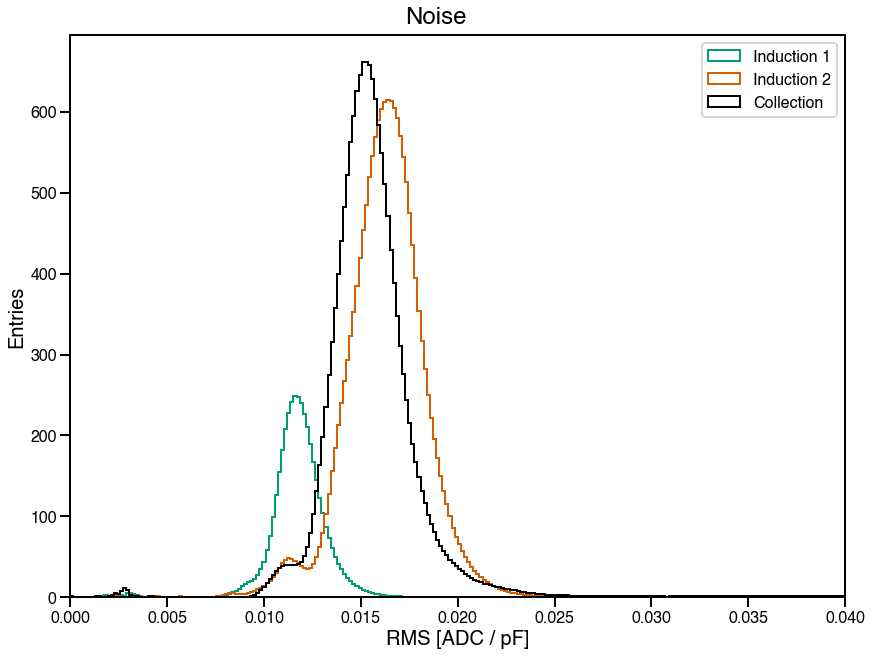

In [7]:
plot_noise(rfcathodeon, norm=True)

An immediate observation is the presence of two distinct populations. The largest consists of overlapping Induction 2 and Collection channels and represents the "standard" population of full-length wires and nominal cable lengths. The smaller population is mostly Induction 1 and some minor population of Induction 2 and Collection channels. To understand why there are two distinct populations, it is useful to first understand what these Induction 2 and Collection wires have in common with Induction 1. It turns out that there are some Induction 2 and Collection wires which terminate on the side of the detector and must have a longer-than-nominal flat cable to connect to the bottom flanges. The longer flat cables is a shared feature for the entries in this second population. Under the assumption that this normalization captures all large variations and therefore should result in a single population, this would suggest that the flat cable capacitance is overestimated. Regardless, this does pull together some of the tails and small populations that existed in the un-normalized plot and makes a much cleaner discriminator for good and bad channels.

### Putting it all together
We now have two discriminators that can be used to characterize the performance of each channel. The main questions to be answered (for each channel) can be summarized simply:
1. Does the channel see signal?
2. Does the channel have irregular noise characteristics?

Each of the above discriminators answers one of these two questions directly. Let's focus on the signal occupancy discriminator first. From the above plots, it is clear that any channel below 2.5% (normalized) occupancy is not seeing signal. This cut could probably be optimized a little more, but the populations are quite separated and little change would occur if the cut were moved leftward or rightward. 

In [8]:
summarize_low_occupancy(rfcathodeon, cut=2.5)

,channel_id,occupancy,reason
0,0,0.966030,Low signal occupancy
1,1,1.008493,Low signal occupancy
2,2,1.326964,Low signal occupancy
3,3,1.836518,Low signal occupancy
4,4,1.815287,Low signal occupancy
...,...,...,...
49598,50110,0.000000,Low signal occupancy
49599,50111,0.000000,Low signal occupancy
49763,50275,0.000000,Low signal occupancy
50161,50673,0.000000,Low signal occupancy


Similarly, low and high noise cuts set at 2.00 ADC and 7.00 ADC (see above non-normalized plot) seem to separate good channels and bad channels quite well. Channels meeting the low or high noise definition more than 5.0% of the time are tagged as bad.

In [9]:
display(summarize_low_noise(rfcathodeon, cut=0.05))
display(summarize_high_noise(rfcathodeon, cut=0.05))

,channel_id,low_noise,reason
34,34,0.656,Low raw noise
1056,1056,1.000,Low raw noise
1057,1057,1.000,Low raw noise
1058,1058,1.000,Low raw noise
1059,1059,1.000,Low raw noise
...,...,...,...
49597,50109,1.000,Low raw noise
49598,50110,1.000,Low raw noise
49599,50111,1.000,Low raw noise
50161,50673,1.000,Low raw noise


,channel_id,high_noise,reason
64,64,0.513,High raw noise
65,65,0.169,High raw noise
66,66,0.253,High raw noise
67,67,0.106,High raw noise
69,69,0.092,High raw noise
...,...,...,...
50524,51036,0.188,High raw noise
51328,51840,0.074,High raw noise
54176,54688,0.081,High raw noise
54759,55271,1.000,High raw noise


From the connectivity test, we also have a list of channels which are not expected to perform well. In addition, there are some channels were isolated at the front-end in order to prevent propagation of noise into the system, many of which had previously been identified in the connectivity test. These collectively make up a list of channels with a known fault in hardware.

In [10]:
summarize_hardware('/Users/mueller/Projects/channel_status/inputs/bad_channels_hardware.csv')

,channel_id,type,reason
0,2013,isolated,isolated
1,1828,isolated,isolated
2,3743,isolated,isolated
3,3725,isolated,isolated
4,4262,isolated,isolated
...,...,...,...
69,43231,sheared,connectivity
70,45756,brokenwire,connectivity
71,48679,extremelylargeresponse,connectivity
72,48696,extremelylargeresponse,connectivity


We can use the union of this information to define a complete list of channels which are not or are not expected to perform normally. The `summarize_all` function displays the unique categories of "bad reasons" along with the count belonging to each.

In [11]:
summaries = [summarize_low_occupancy(rfcathodeon, cut=2.5), summarize_low_noise(rfcathodeon, cut=0.05), summarize_high_noise(rfcathodeon, cut=0.05), summarize_hardware('/Users/mueller/Projects/channel_status/inputs/bad_channels_hardware.csv')]
df = summarize_all(summaries)
print(f'Total bad: {len(df)}')

Reason: Connectivity, Count: 22
Reason: High raw noise, Count: 419
Reason: Low raw noise, Count: 518
Reason: Low raw noise & Isolated, Count: 4
Reason: Low signal occupancy, Count: 240
Reason: Low signal occupancy & Connectivity, Count: 5
Reason: Low signal occupancy & High raw noise, Count: 6
Reason: Low signal occupancy & Low raw noise, Count: 71
Reason: Low signal occupancy & Low raw noise & Connectivity, Count: 25
Reason: Low signal occupancy & Low raw noise & Isolated, Count: 14
Reason: Low signal occupancy & Low raw noise & Isolated & Connectivity, Count: 2
Total bad: 1326


Finally, we can copy the ICARUS channel information database (as shown in hte `tpc_database` project) and add to it a list of identified bad channels. This allows for easy cross-referencing of the variety of information that may be useful for diagnostics.

In [12]:
export_channel_status('/Users/mueller/data/icarus_channel_status_dev.db', '/Users/mueller/Projects/channel_status/db/icarus_channels.db', df)